# Italian COVID-19 Analysis through a skew normal distribution
This notebook analyses data related to the Italian COVID-19 trend. Data are released by the Italian Protezione Civile. The general concepts behind this predictor are described in the following article: https://medium.com/@angelica.loduca/predicting-the-end-of-the-coronavirus-epidemics-in-italy-8da9811f7740. With respect to my [previous article](https://towardsdatascience.com/italian-covid-19-analysis-with-python-1bdb0e64d5ac), where I used a linear regression to approximate data, in this article we approximate EPI through a skewed normal distribution, which seems to work better than linear regression.

## Getting Started
Firstly, we import data from the Github repository of the Italian Protezione Civile and then we calculate the Epidemics Progression Index (EPI). We extract columns `totale_casi`, which contains the total number of covid-19 infections since the epidemics began, and `tamponi`, which contains the total number of covid-19 swabs since the epidemics began. We store EPI in the `y` variable. Finally, we print all the list of dates for which we have data (`data['data']`).

In [2]:
import pandas as pd 

data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv") 
data.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,7,229,4324,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,10,322,8623,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,12,400,9587,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,17,650,12014,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,21,888,15695,NaN,NaN,NaN


Then, we calculate the metrics to analyse: Epidemics Progresion Index (EPI) and we store it in the `y` variable. We define also `X` to store number of days. Finally, we skip the first 15 days, to consider the effects of restriction laws.

In [3]:
tc = data['totale_casi']
tt = data['tamponi']
y = []
tt_increase = []
for i in range(1, len(tt)):
    current_epi = (tc[i] - tc[i-1])/(tt[i]-tt[i-1])
    tt_increase.append(tt[i]-tt[i-1])
    y.append(current_epi)

X = []
for i in range(1, len(y)+1):
    X.append(i)

skip = 15
X = X[skip:]
y = y[skip:]

Now we can plot the EPI trend.

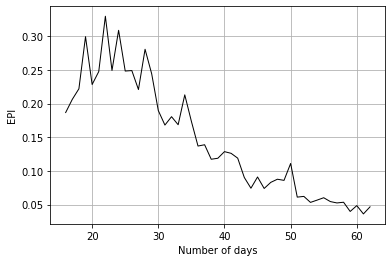

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


def my_plot(X,y):
    plt.plot(X, y, color="black", linewidth=1)

    plt.grid()
    plt.xlabel('Number of days')
    plt.ylabel('EPI')
    plt.savefig('data/EPI.png')
    plt.show()

my_plot(X,y)

## Extract a sample
In order to test the model, we split `X` and `y` in `X_train` and `y_train`. We will train the model on the train variables and test will be done on the test variables.

In [6]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Model Definition
We can approximate data through a skewed normal distribution. We tranform `X` and `y` into numpy arrays and we define a function, called `skewnorm()`, which contains the formula of the skewed normal distribution. I found the formula [here](https://stackoverflow.com/questions/15400850/scipy-optimize-curve-fit-unable-to-fit-shifted-skewed-gaussian-curve). Give a look [here](https://www.vosesoftware.com/riskwiki/SkewNormaldistribution.php) for more details about the skewed normal distribution. Alternatively, we could use the function `scipy.stats.skewnorm`, defined [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html), [here](https://kite.com/python/docs/scipy.stats.norm) and [here](https://www.geeksforgeeks.org/python-skew-normal-distribution-in-statistics/).

In [7]:
import numpy as np
import math
from scipy.optimize import curve_fit
import scipy.special as sp

X = np.array(X)
y = np.array(y)


def skewnorm(x, sigmag, mu, alpha, c,a):
    
    normpdf = (1/(sigmag*np.sqrt(2*math.pi)))*np.exp(-(np.power((x-mu),2)/(2*np.power(sigmag,2))))
    
    normcdf = (0.5*(1+sp.erf((alpha*((x-mu)/sigmag))/(np.sqrt(2)))))
    return 2*a*normpdf*normcdf + c



Now we are able to fit the model with the training data through the `scipy` function `curve_fit()`. Curve fitting is the process of constructing a curve, or mathematical function, that has the best fit to a series of data points. The `curve_fit()` function takes the samples as input, as well as the initial parameters. The function returns the best parameters `popt` and the covariance matrix `pcov` as output.

In [8]:
popt, pcov = curve_fit(skewnorm, X_train, y_train, p0=(1./np.std(y_train), np.mean(y_train) ,0,0,0))

After fitting, we plot results for the training set. We calculate the prediction `y_train_pred` simply calling the function `skewnorm()` with the parameters returned by the `curve_fit()` function.

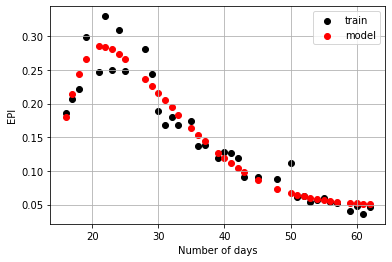

In [9]:
y_train_pred = skewnorm(X_train,*popt) 

plt.scatter(X_train, y_train, color="black", linewidth=1, label='train')
plt.scatter(X_train, y_train_pred, color="red", linewidth=1, label='model')
plt.grid()
plt.legend()
plt.xlabel('Number of days')
plt.ylabel('EPI')
plt.savefig('data/skew-train.png')
plt.show()

## Model Evaluation
We test the model on the remaining part of `X`, i.e. `X_test`. We apply the function `skewnorm()` to `X_test`. 

In [286]:
y_pred = skewnorm(X_test,*popt)

We compare predicted values, with actual values.

In [287]:
df = pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,0.074226,0.092096
1,0.085873,0.070353
2,0.073857,0.081997
3,0.228241,0.279068
4,0.212904,0.173161
5,0.220810,0.247001
6,0.053406,0.053488
7,0.082920,0.077674
8,0.117260,0.134936
9,0.248975,0.256744


We calculate all the evaluation metrics. Please, give a look at: https://www.datavedas.com/model-evaluation-regression-models/ for more details.

We want the value of RMSE to be as low as possible, as lower the RMSE value is, the better the model is with its predictions.

In [288]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.018906418551917548
Mean Squared Error: 0.0005875686759848301
Root Mean Squared Error: 0.024239815923080565


We calculate also the Pearsons correlation coefficient to establish whether between the actual and predicted values there is a correlation. We use the `pearsonr()` function contained in the `stats` library. This function returns the Pearsons correlation coefficient as first parameter and the p-value as second parameter.

### Pearsons Correlation Coefficient
Perfect: If the value is near ± 1, then it said to be a perfect correlation: as one variable increases, the other variable tends to also increase (if positive) or decrease (if negative).

High degree: If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation. Moderate degree: If the value lies between ± 0.30 and ± 0.49, then it is said to be a medium correlation. Low degree: When the value lies below + .29, then it is said to be a small correlation. No correlation: When the value is zero.
Related Page: https://www.statisticssolutions.com/pearsons-correlation-coefficient/ 

### P-value
We want to keep it as small as possible. Related page: https://it.wikipedia.org/wiki/Valore_p

In [249]:
from scipy import stats

stats.pearsonr(y_test, y_pred)

(0.960573970542586, 1.0078906799992487e-05)

## Extend the model to the whole population
The whole population is composed of `X` and `y`. We calculate `y_pred` by applying the `skewnorm()` function to `X`. Then we plot results.

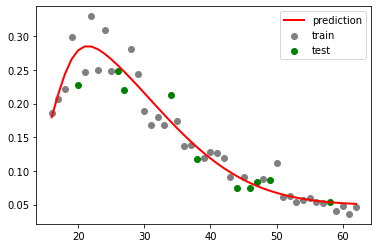

In [10]:
y_pred = skewnorm(X,*popt)
plt.scatter(X_train, y_train, color="gray", label='train')
plt.scatter(X_test, y_test,  color='green', label='test')
plt.plot(X, y_pred, color='red', linewidth=2, label='prediction')
plt.legend()
plt.savefig('data/skewnorm.png')
plt.show()

## Future Trend Prediction
Now we try to predict the future trend for the next 50 days. We build a list `X_future` starting from the last day + 1 contained in `X`. Then we apply the function `skewnorm()` to `X_future` and we plot results.

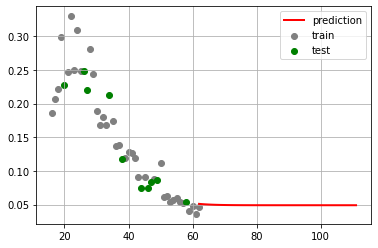

In [11]:
X_future = []
n_start = skip+len(X)
for i in range(n_start, n_start + 50):
    X_future.append([i])

y_future = skewnorm(X_future,*popt)

plt.scatter(X_train, y_train, color="gray", label='train')
plt.scatter(X_test, y_test,  color='green', label='test')
plt.plot(X_future, y_future, color='red', linewidth=2, label='prediction')
plt.legend()
plt.grid()
plt.savefig('data/future.png')
plt.show()

In [255]:
y_future

array([[0.05097314],
       [0.0505846 ],
       [0.05026482],
       [0.05000295],
       [0.04978957],
       [0.04961658],
       [0.04947702],
       [0.049365  ],
       [0.04927552],
       [0.04920441],
       [0.04914816],
       [0.0491039 ],
       [0.04906924],
       [0.04904222],
       [0.04902127],
       [0.0490051 ],
       [0.04899268],
       [0.04898319],
       [0.04897597],
       [0.04897051],
       [0.04896639],
       [0.04896331],
       [0.04896101],
       [0.0489593 ],
       [0.04895804],
       [0.04895711],
       [0.04895643],
       [0.04895594],
       [0.04895558],
       [0.04895532],
       [0.04895513],
       [0.048955  ],
       [0.0489549 ],
       [0.04895484],
       [0.04895479],
       [0.04895476],
       [0.04895474],
       [0.04895472],
       [0.04895471],
       [0.0489547 ],
       [0.0489547 ],
       [0.04895469],
       [0.04895469],
       [0.04895469],
       [0.04895469],
       [0.04895469],
       [0.04895469],
       [0.048

Now, we can predict the end of COVID-19 outbreak. This will occur when the value of y is equal to the offset `c`, defined in the skewnorm formula (`y[i] = c`). Since `c` is a float number, we convert it to int, after having shifted the comma. The value of `c` is contained in the `popt` variable, returned by the `curve_fit()`. We convert also `y_future` to int, by apply the same technique of `c`. Finally, we use the function `np.where()` to find the index `i` such that `y[i] = c`. 

In [272]:
c = int(popt[3]*10**9)
y_search = np.array([int(i*10**9) for i in y_future])
i = np.where(y_search == c)
i

(array([48, 49]),)

We obtain two indexes, we take the first and we store it in `x0`.

In [280]:
x0 = i[0][0] + n_start
y_future[i[0][0]]

array([0.04895468])

In [281]:
c

48954684

Convert number of days to date. Data start from 2020 February 24. Then we have skipped 15 days.

In [275]:
from datetime import datetime
from datetime import timedelta  
data_eff = datetime.strptime(data['data'][skip], '%Y-%m-%dT%H:%M:%S')
data['data'][skip]

'2020-03-10T18:00:00'

Now we are able to calculate the end of COVID-19 outbreak, simply converting `x0` to a date.

In [290]:
def n_to_date(n):
    return data_eff + timedelta(days=n-skip)

n_to_date(int(x0))

datetime.datetime(2020, 6, 13, 18, 0)

Finally, we implement a function to predict the value of EPI for a generic date.

In [291]:
def date_to_n(my_date):
    initial_date = datetime.strptime(data['data'][0], '%Y-%m-%dT%H:%M:%S')
    return (my_date - initial_date).days + 1

my_date = datetime.strptime("2020-04-25", '%Y-%m-%d')
n = date_to_n(my_date)
predict = skewnorm([[n]],*popt)
predict

array([[0.05144282]])